 <img src="./images/scp_common_distribution.png" width="500">

In [2]:
!pwd

/work/files/workspace


# Which tree species should the city plant?

## 📖 Background
You work for a nonprofit organization advising the planning department on ways to improve the quantity and quality of trees in New York City. The urban design team believes tree size (using trunk diameter as a proxy for size) and health are the most desirable characteristics of city trees.

The city would like to learn more about which tree species are the best choice to plant on the streets of Manhattan.

## 💾 The data
The team has provided access to the 2015 tree census and geographical information on New York City neighborhoods ([trees](https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh), [neighborhoods](https://data.cityofnewyork.us/City-Government/NTA-map/d3qk-pfyz)):

#### Tree Census
- "tree_id" - Unique id of each tree.
- "tree_dbh" - The diameter of the tree in inches measured at 54 inches above the ground.
- "curb_loc" - Location of the tree bed in relation to the curb. Either along the curb (OnCurb) or offset from the curb (OffsetFromCurb).
- "spc_common" - Common name for the species.
- "status" - Indicates whether the tree is alive or standing dead.
- "health" - Indication of the tree's health (Good, Fair, and Poor).
- "root_stone" - Indicates the presence of a root problem caused by paving stones in the tree bed.
- "root_grate" - Indicates the presence of a root problem caused by metal grates in the tree bed.
- "root_other" - Indicates the presence of other root problems.
- "trunk_wire" - Indicates the presence of a trunk problem caused by wires or rope wrapped around the trunk.
- "trnk_light" - Indicates the presence of a trunk problem caused by lighting installed on the tree.
- "trnk_other" - Indicates the presence of other trunk problems.
- "brch_light" - Indicates the presence of a branch problem caused by lights or wires in the branches.
- "brch_shoe" - Indicates the presence of a branch problem caused by shoes in the branches.
- "brch_other" - Indicates the presence of other branch problems.
- "postcode" - Five-digit zip code where the tree is located.
- "nta" - Neighborhood Tabulation Area (NTA) code from the 2010 US Census for the tree.
- "nta_name" - Neighborhood name.
- "latitude" - Latitude of the tree, in decimal degrees.
- "longitude" - Longitude of the tree, in decimal degrees.

#### Neighborhoods' geographical information
- "ntacode" - NTA code (matches Tree Census information).
- "ntaname" - Neighborhood name (matches Tree Census information).
- "geometry" - Polygon that defines the neighborhood.

_Tree census and neighborhood information from the City of New York [NYC Open Data](https://opendata.cityofnewyork.us/data/)._

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

#PLOTTING
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
import matplotlib as mpl

from shapely import geometry
from shapely.ops import cascaded_union

#KDE
#from scipy.stats import gaussian_kde
from scipy.optimize import fsolve #will use this to find median of a KDE estimate conditioned on location (e.g. tree diameter)
from statsmodels.nonparametric.kernel_density import KDEMultivariateConditional
from statsmodels.nonparametric.kernel_density import KDEMultivariate

# IMPORT DATA

In [2]:
trees = pd.read_csv('data/trees.csv')
trees.head()

,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude
0,190422,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770046,-73.984950
1,190426,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770210,-73.985338
2,208649,9,OnCurb,American linden,Alive,Good,No,Yes,No,No,No,No,No,No,No,10019,MN15,Clinton,40.762724,-73.987297
3,193310,14,OnCurb,honeylocust,Alive,Good,No,No,Yes,No,No,Yes,No,No,Yes,10021,MN40,Upper East Side-Carnegie Hill,40.772171,-73.960456
4,199760,4,OnCurb,willow oak,Alive,Fair,No,No,No,No,No,No,No,No,No,10024,MN12,Upper West Side,40.782087,-73.980964


## Add geometry column to *trees* (GeoDataFrame)

In [3]:
trees = gpd.GeoDataFrame(trees, geometry=gpd.GeoSeries.from_xy(trees['longitude'], trees['latitude']))
trees.head()

,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude,geometry
0,190422,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770046,-73.984950,POINT (-73.98495 40.77005)
1,190426,11,OnCurb,honeylocust,Alive,Good,No,No,No,No,No,No,No,No,No,10023,MN14,Lincoln Square,40.770210,-73.985338,POINT (-73.98534 40.77021)
2,208649,9,OnCurb,American linden,Alive,Good,No,Yes,No,No,No,No,No,No,No,10019,MN15,Clinton,40.762724,-73.987297,POINT (-73.98730 40.76272)
3,193310,14,OnCurb,honeylocust,Alive,Good,No,No,Yes,No,No,Yes,No,No,Yes,10021,MN40,Upper East Side-Carnegie Hill,40.772171,-73.960456,POINT (-73.96046 40.77217)
4,199760,4,OnCurb,willow oak,Alive,Fair,No,No,No,No,No,No,No,No,No,10024,MN12,Upper West Side,40.782087,-73.980964,POINT (-73.98096 40.78209)


In [4]:
neighborhoods = gpd.read_file('data/nta.shp')
neighborhoods.head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
0,3.0,Brooklyn,047,BK43,Midwood,3.579964e+07,27996.591274,"POLYGON ((-73.94733 40.62917, -73.94687 40.626..."
1,3.0,Brooklyn,047,BK75,Bedford,3.262983e+07,29992.919174,"POLYGON ((-73.94193 40.70073, -73.94439 40.700..."
2,2.0,Bronx,005,BX40,Fordham South,6.307284e+06,15878.272921,"POLYGON ((-73.89138 40.86170, -73.89106 40.861..."
3,3.0,Brooklyn,047,BK88,Borough Park,5.400502e+07,39247.227722,"POLYGON ((-73.97605 40.63128, -73.97717 40.630..."
4,3.0,Brooklyn,047,BK96,Rugby-Remsen Village,3.270695e+07,30957.853395,"POLYGON ((-73.90856 40.65210, -73.90945 40.651..."


## Check for missing values
- No missing values in the *neighborhoods* dataframe

In [5]:
neighborhoods.isna().sum()

borocode      0
boroname      0
countyfips    0
ntacode       0
ntaname       0
shape_area    0
shape_leng    0
geometry      0
dtype: int64

- All missing species entries are dead trees
- One honeylocust tree is dead and therefore the health info is na

In [6]:
trees.isna().sum()

tree_id          0
tree_dbh         0
curb_loc         0
spc_common    1801
status           0
health        1802
root_stone       0
root_grate       0
root_other       0
trunk_wire       0
trnk_light       0
trnk_other       0
brch_light       0
brch_shoe        0
brch_other       0
postcode         0
nta              0
nta_name         0
latitude         0
longitude        0
geometry         0
dtype: int64

In [7]:
#Crosstab to show which trees have no species info
pd.crosstab(trees.spc_common.isna().rename(index='missing spc info'), [trees.health.fillna('missing health info'), trees.status])

health,Fair,Good,Poor,missing health info
status,Alive,Alive,Alive,Dead
missing spc info,,,,
False,11460,47358,3609,1
True,0,0,0,1801


In [8]:
#Show the one dead tree of a known specie
trees[(trees.status=='Dead') & ~trees.spc_common.isna()]

,tree_id,tree_dbh,curb_loc,spc_common,status,health,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude,geometry
28539,473703,12,OffsetFromCurb,honeylocust,Dead,NaN,No,No,No,No,No,No,No,No,No,10002,MN28,Lower East Side,40.710384,-73.988208,POINT (-73.98821 40.71038)


## Combine the *status* and *health* columns in a new columns (*Dead* tree status will be included in *health*)

### Replace missing health values with status (*Dead*)

In [9]:
trees.insert(6, "health_CAT", trees.health.fillna(trees.status).astype('category'))

In [10]:
trees.health_CAT.unique()

['Good', 'Fair', 'Dead', 'Poor']
Categories (4, object): ['Dead', 'Fair', 'Good', 'Poor']

In [11]:
trees.health_CAT.cat.set_categories(['Good', 'Fair', 'Poor', 'Dead'], ordered=True, inplace=True)

In [12]:
trees.health_CAT.unique()

['Good', 'Fair', 'Dead', 'Poor']
Categories (4, object): ['Good' < 'Fair' < 'Poor' < 'Dead']

### Print some lines representing a mix of live and dead trees to demonstrate the change

In [13]:
trees[(trees.status != trees.shift(-1).status) | (trees.status != trees.shift(-1).status)].health_CAT.cat.codes

78       0
79       3
105      1
106      3
168      0
        ..
63982    0
63983    3
64209    0
64210    3
64228    0
Length: 3193, dtype: int8

In [14]:
trees[(trees.status != trees.shift(-1).status) | (trees.status != trees.shift(-1).status)].loc[:,'tree_id':'health_CAT']

,tree_id,tree_dbh,curb_loc,spc_common,status,health,health_CAT
78,206382,11,OnCurb,honeylocust,Alive,Good,Good
79,188609,9,OnCurb,NaN,Dead,NaN,Dead
105,120819,3,OnCurb,swamp white oak,Alive,Fair,Fair
106,189412,7,OnCurb,NaN,Dead,NaN,Dead
168,170505,10,OnCurb,Japanese zelkova,Alive,Good,Good
...,...,...,...,...,...,...,...
63982,196687,4,OnCurb,black oak,Alive,Good,Good
63983,196070,0,OnCurb,NaN,Dead,NaN,Dead
64209,186932,5,OnCurb,honeylocust,Alive,Good,Good
64210,156162,3,OffsetFromCurb,NaN,Dead,NaN,Dead


In [15]:
trees[(trees.status != trees.shift(-1).status) | (trees.status != trees.shift(-1).status)].loc[:,'tree_id':'health_CAT']

,tree_id,tree_dbh,curb_loc,spc_common,status,health,health_CAT
78,206382,11,OnCurb,honeylocust,Alive,Good,Good
79,188609,9,OnCurb,NaN,Dead,NaN,Dead
105,120819,3,OnCurb,swamp white oak,Alive,Fair,Fair
106,189412,7,OnCurb,NaN,Dead,NaN,Dead
168,170505,10,OnCurb,Japanese zelkova,Alive,Good,Good
...,...,...,...,...,...,...,...
63982,196687,4,OnCurb,black oak,Alive,Good,Good
63983,196070,0,OnCurb,NaN,Dead,NaN,Dead
64209,186932,5,OnCurb,honeylocust,Alive,Good,Good
64210,156162,3,OffsetFromCurb,NaN,Dead,NaN,Dead


### Convert other columns to categories

In [16]:
trees.columns

Index(['tree_id', 'tree_dbh', 'curb_loc', 'spc_common', 'status', 'health',
       'health_CAT', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trnk_light', 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other',
       'postcode', 'nta', 'nta_name', 'latitude', 'longitude', 'geometry'],
      dtype='object')

In [17]:
columns_categorical = ['curb_loc', 'spc_common', 'root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trnk_light',
 'trnk_other', 'brch_light', 'brch_shoe', 'brch_other']

In [18]:
for col in columns_categorical:
    trees[col] = trees[col].astype('category')

In [19]:
#trees.spc_common = trees.spc_common.astype('category')

In [20]:
trees.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64229 entries, 0 to 64228
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tree_id     64229 non-null  int64   
 1   tree_dbh    64229 non-null  int64   
 2   curb_loc    64229 non-null  category
 3   spc_common  62428 non-null  category
 4   status      64229 non-null  object  
 5   health      62427 non-null  object  
 6   health_CAT  64229 non-null  category
 7   root_stone  64229 non-null  category
 8   root_grate  64229 non-null  category
 9   root_other  64229 non-null  category
 10  trunk_wire  64229 non-null  category
 11  trnk_light  64229 non-null  category
 12  trnk_other  64229 non-null  category
 13  brch_light  64229 non-null  category
 14  brch_shoe   64229 non-null  category
 15  brch_other  64229 non-null  category
 16  postcode    64229 non-null  int64   
 17  nta         64229 non-null  object  
 18  nta_name    64229 non-null  object  
 

In [21]:
# tree_health_cm = dict(zip(['Good', 'Fair', np.NaN, 'Poor'], ['green', 'orange', 'grey', 'red']))

## Trunc diameter distribution

<AxesSubplot:xlabel='tree_dbh', ylabel='Proportion'>

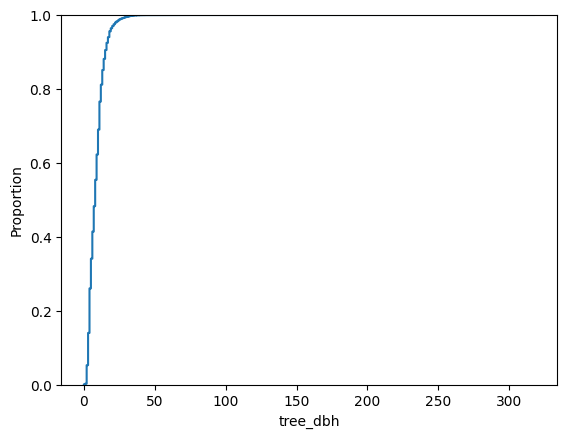

In [22]:
sns.ecdfplot(data=trees, x="tree_dbh")

### Diamaters of some tree are too large, probably not measured as a trunc diameter, let's look at the outliers

In [23]:
trees[trees['tree_dbh']==trees['tree_dbh'].max()]

,tree_id,tree_dbh,curb_loc,spc_common,status,health,health_CAT,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,postcode,nta,nta_name,latitude,longitude,geometry
28786,476317,318,OnCurb,pin oak,Alive,Good,Good,No,No,No,No,No,No,No,No,No,10033,MN35,Washington Heights North,40.850879,-73.943067,POINT (-73.94307 40.85088)


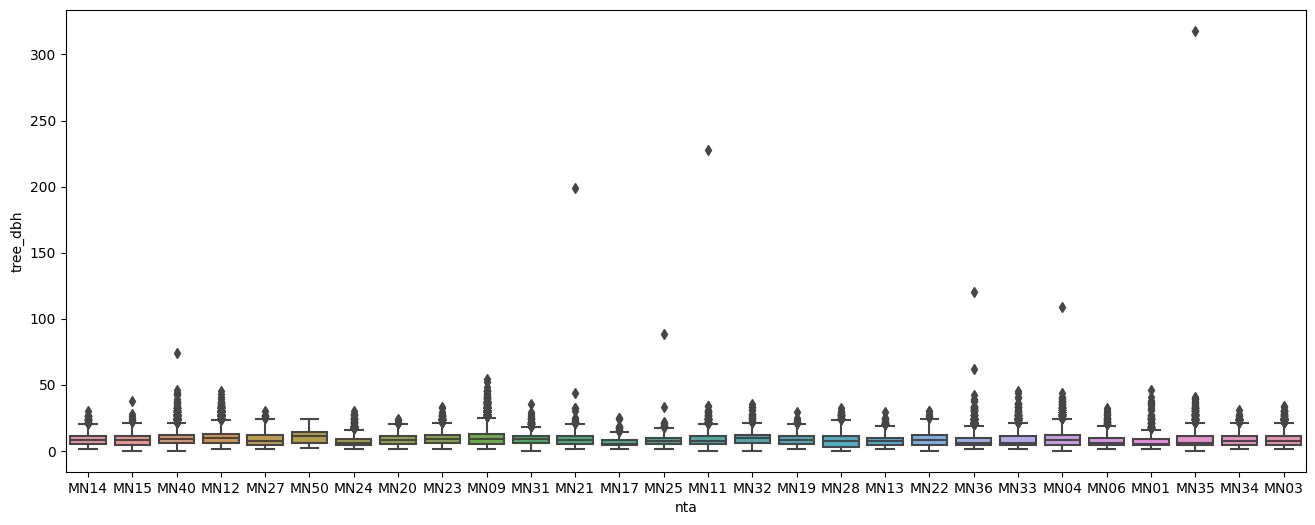

In [24]:
fig, ax = plt.subplots(1,1,figsize=(16,6));
sns.boxplot(data=trees, orient='v', y='tree_dbh', x='nta', ax=ax);

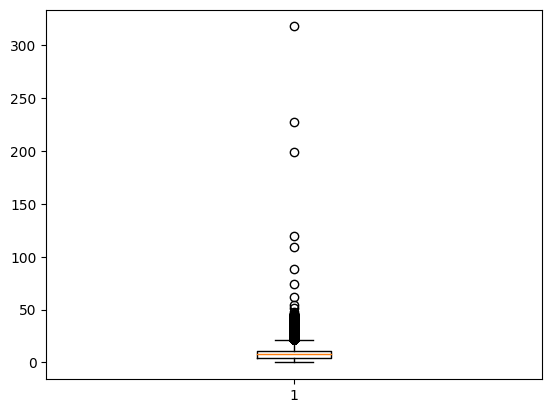

In [25]:
tree_dbh_bplot = plt.boxplot(trees['tree_dbh'])
#bplot['fliers'][0].get_ydata().min()

In [26]:
tree_dbh_bplot['fliers'][0].get_ydata()

array([29, 26, 24, ..., 22, 22, 23])

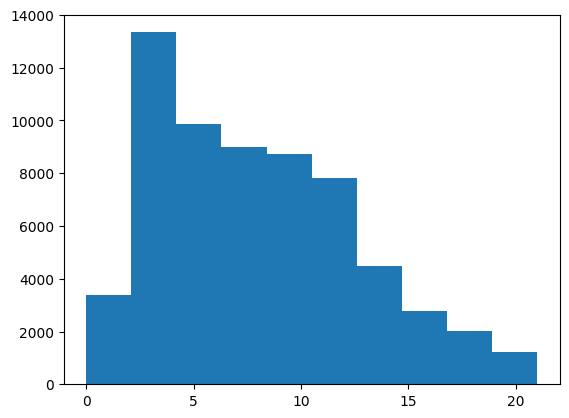

In [27]:
plt.hist(trees[trees['tree_dbh']<tree_dbh_bplot['fliers'][0].get_ydata().min()]['tree_dbh']);

In [28]:
vmin, vmax = (lambda x: tuple([min(x), max(x)]))(np.hstack([xy1.get_ydata() for xy1 in tree_dbh_bplot['whiskers']]))
norm = Normalize(vmin=vmin, vmax=vmax)
#norm = LogNorm(vmin=vmin, vmax=vmax)

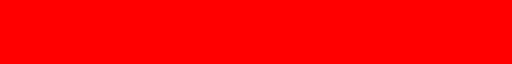

In [29]:
ListedColormap(cm.rainbow(norm(21)))

In [30]:
np.array(cm.summer(norm(trees['tree_dbh'])))[:,:-1]

array([[0.5254902 , 0.7627451 , 0.4       ],
       [0.5254902 , 0.7627451 , 0.4       ],
       [0.42745098, 0.71372549, 0.4       ],
       ...,
       [0.4745098 , 0.7372549 , 0.4       ],
       [0.57254902, 0.78627451, 0.4       ],
       [0.23529412, 0.61764706, 0.4       ]])

### Just plot all available colormaps to choose from

magma


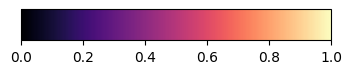

inferno


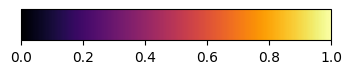

plasma


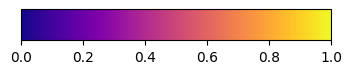

viridis


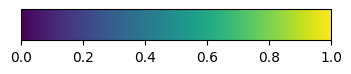

cividis


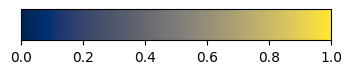

twilight


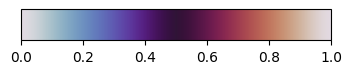

twilight_shifted


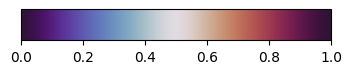

turbo


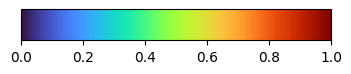

Blues


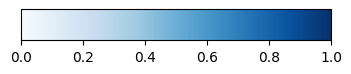

BrBG


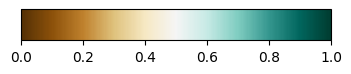

BuGn


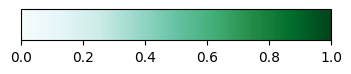

BuPu


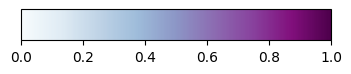

CMRmap


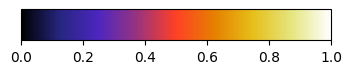

GnBu


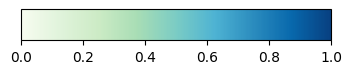

Greens


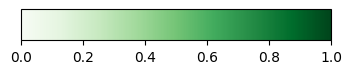

Greys


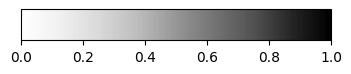

OrRd


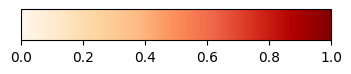

Oranges


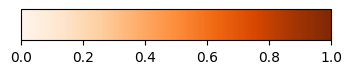

PRGn


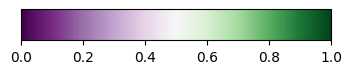

PiYG


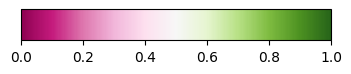

PuBu


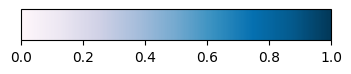

PuBuGn


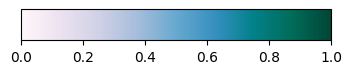

PuOr


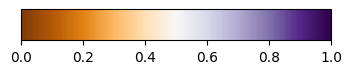

PuRd


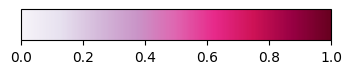

Purples


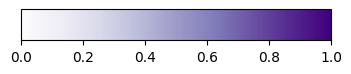

RdBu


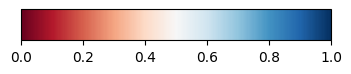

RdGy


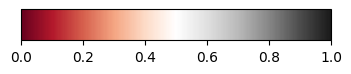

RdPu


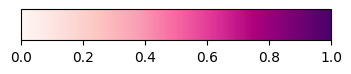

RdYlBu


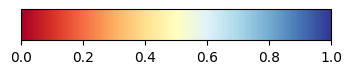

RdYlGn


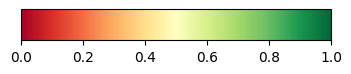

Reds


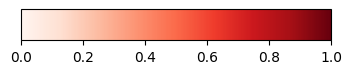

Spectral


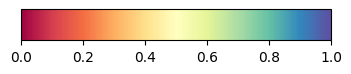

Wistia


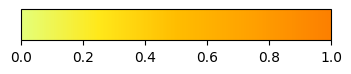

YlGn


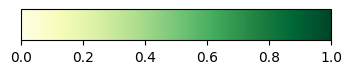

YlGnBu


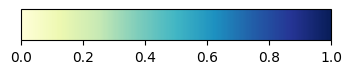

YlOrBr


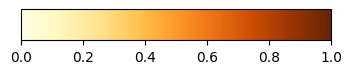

YlOrRd


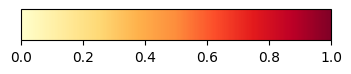

afmhot


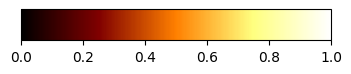

autumn


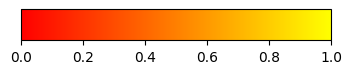

binary


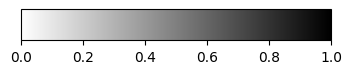

bone


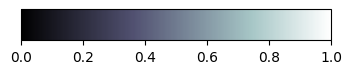

brg


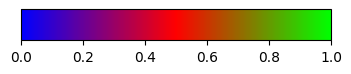

bwr


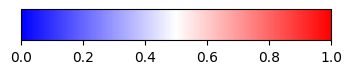

cool


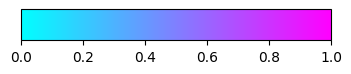

coolwarm


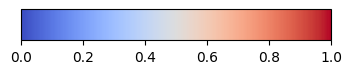

copper


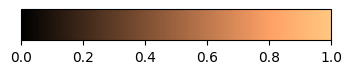

cubehelix


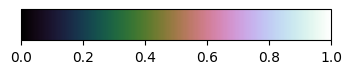

flag


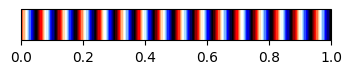

gist_earth


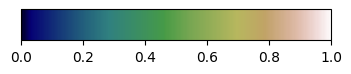

gist_gray


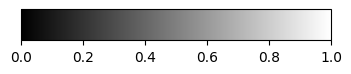

gist_heat


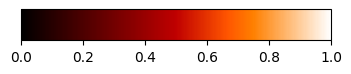

gist_ncar


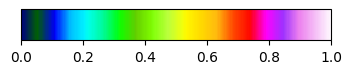

gist_rainbow


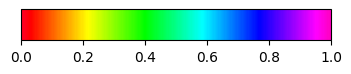

gist_stern


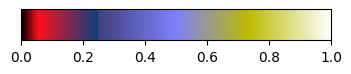

gist_yarg


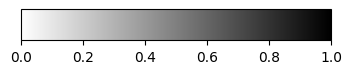

gnuplot


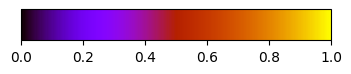

gnuplot2


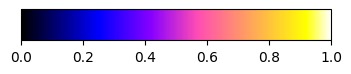

gray


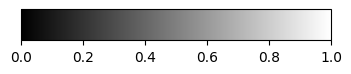

hot


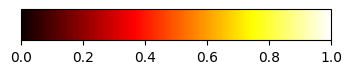

hsv


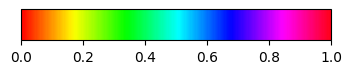

jet


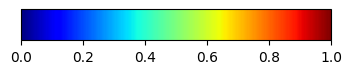

nipy_spectral


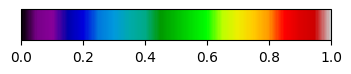

ocean


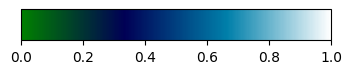

pink


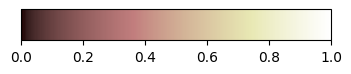

prism


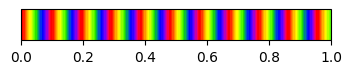

rainbow


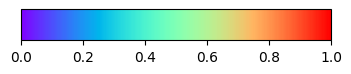

seismic


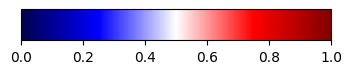

spring


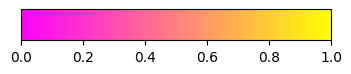

summer


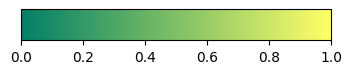

terrain


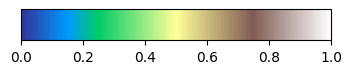

winter


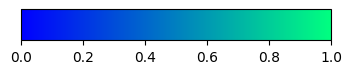

Accent


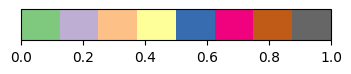

Dark2


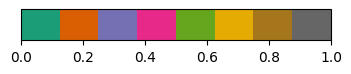

Paired


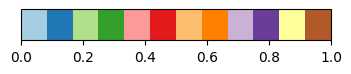

Pastel1


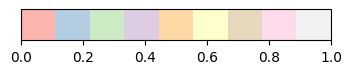

Pastel2


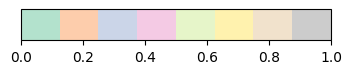

Set1


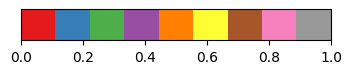

Set2


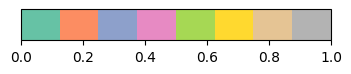

Set3


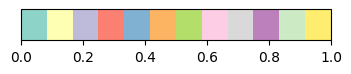

tab10


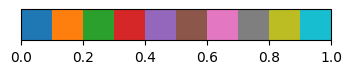

tab20


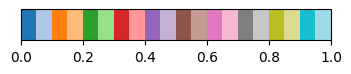

tab20b


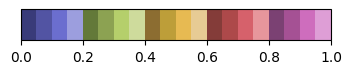

tab20c


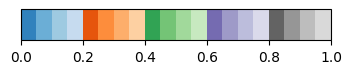

magma_r


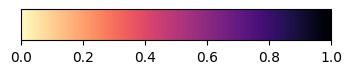

inferno_r


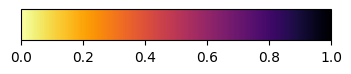

plasma_r


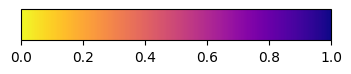

viridis_r


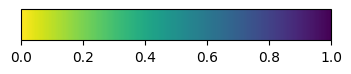

cividis_r


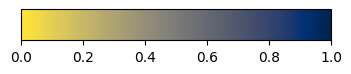

twilight_r


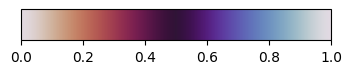

twilight_shifted_r


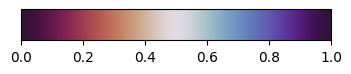

turbo_r


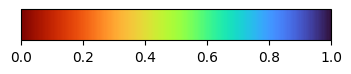

Blues_r


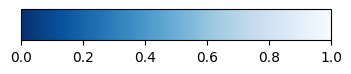

BrBG_r


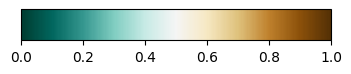

BuGn_r


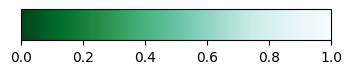

BuPu_r


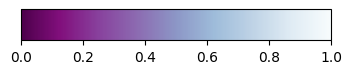

CMRmap_r


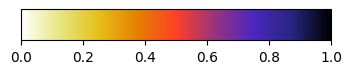

GnBu_r


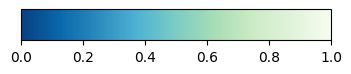

Greens_r


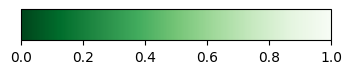

Greys_r


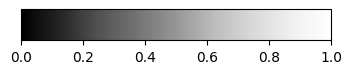

OrRd_r


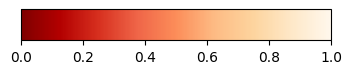

Oranges_r


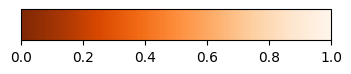

PRGn_r


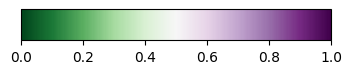

PiYG_r


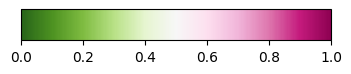

PuBu_r


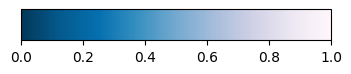

PuBuGn_r


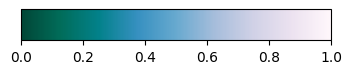

PuOr_r


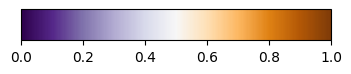

PuRd_r


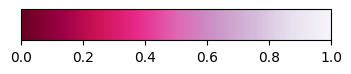

Purples_r


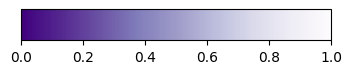

RdBu_r


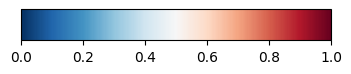

RdGy_r


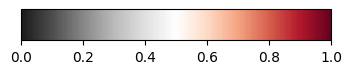

RdPu_r


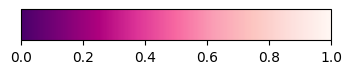

RdYlBu_r


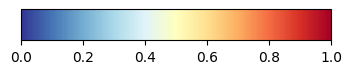

RdYlGn_r


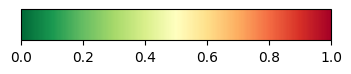

Reds_r


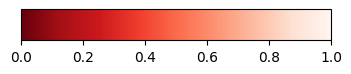

Spectral_r


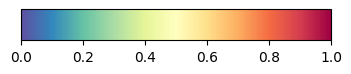

Wistia_r


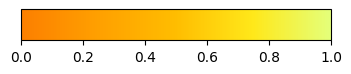

YlGn_r


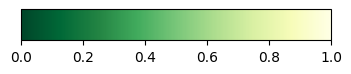

YlGnBu_r


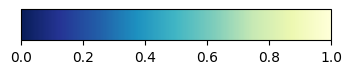

YlOrBr_r


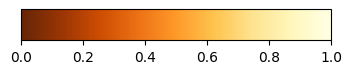

YlOrRd_r


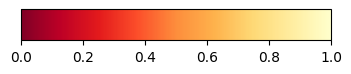

afmhot_r


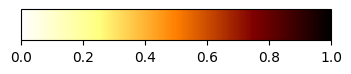

autumn_r


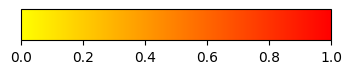

binary_r


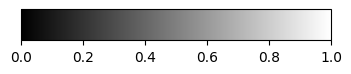

bone_r


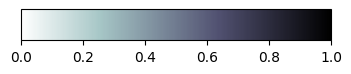

brg_r


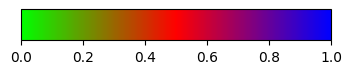

bwr_r


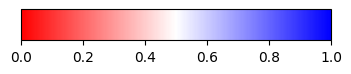

cool_r


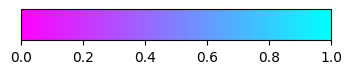

coolwarm_r


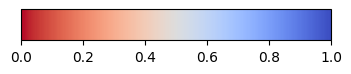

copper_r


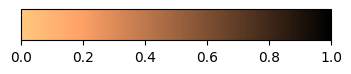

cubehelix_r


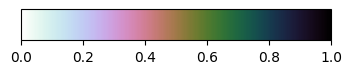

flag_r


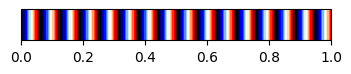

gist_earth_r


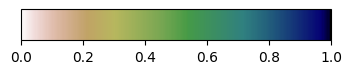

gist_gray_r


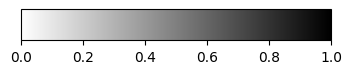

gist_heat_r


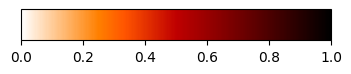

gist_ncar_r


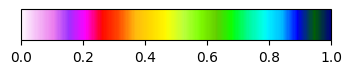

gist_rainbow_r


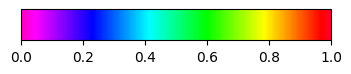

gist_stern_r


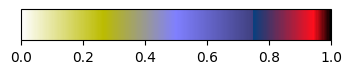

gist_yarg_r


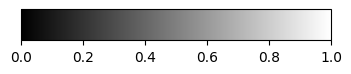

gnuplot_r


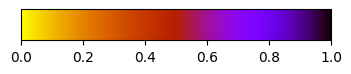

gnuplot2_r


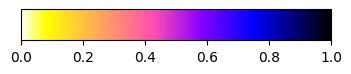

gray_r


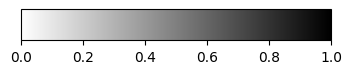

hot_r


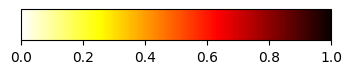

hsv_r


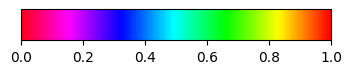

jet_r


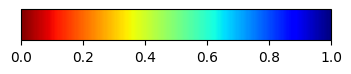

nipy_spectral_r


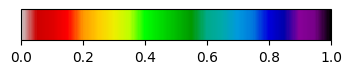

ocean_r


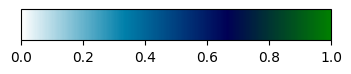

pink_r


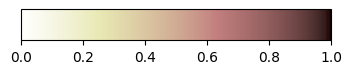

prism_r


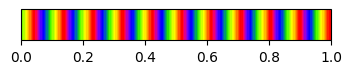

rainbow_r


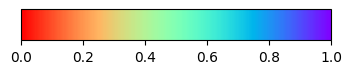

seismic_r


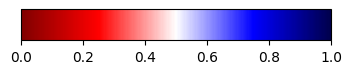

spring_r


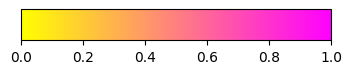

summer_r


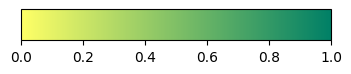

terrain_r


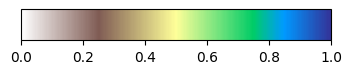

winter_r


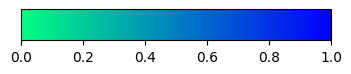

Accent_r


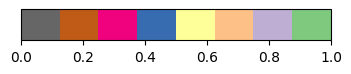

Dark2_r


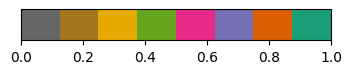

Paired_r


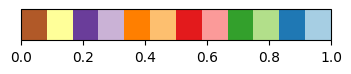

Pastel1_r


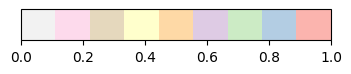

Pastel2_r


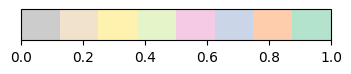

Set1_r


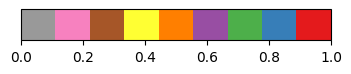

Set2_r


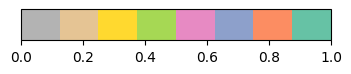

Set3_r


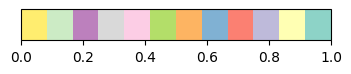

tab10_r


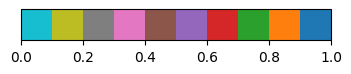

tab20_r


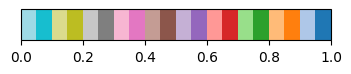

tab20b_r


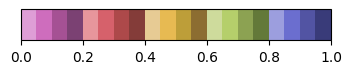

tab20c_r


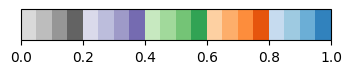

rocket


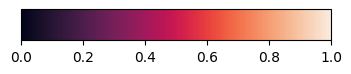

rocket_r


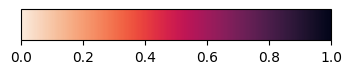

mako


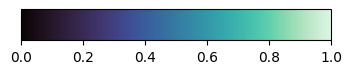

mako_r


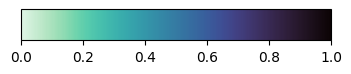

icefire


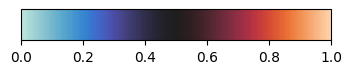

icefire_r


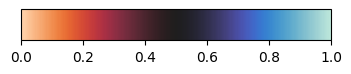

vlag


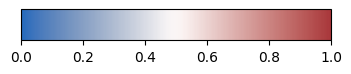

vlag_r


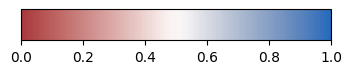

flare


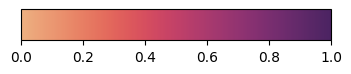

flare_r


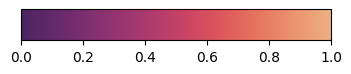

crest


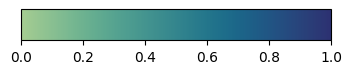

crest_r


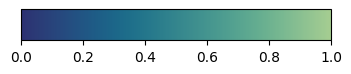

In [31]:
from matplotlib.colorbar import ColorbarBase

def plot_colorMaps(cmap):

    fig, ax = plt.subplots(figsize=(4,0.4))
    col_map = plt.get_cmap(cmap)
    ColorbarBase(ax, cmap=col_map, orientation = 'horizontal')

    plt.show()

for cmap_id in plt.colormaps():
    print(cmap_id)
    plot_colorMaps(cmap_id)

### PLOT DISTRIBUTION OF ALL SPECIES

In [32]:
trees.spc_common.value_counts()

honeylocust           13176
Callery pear           7297
ginkgo                 5859
pin oak                4584
Sophora                4453
                      ...  
pignut hickory            1
red pine                  1
red horse chestnut        1
Persian ironwood          1
white pine                1
Name: spc_common, Length: 128, dtype: int64

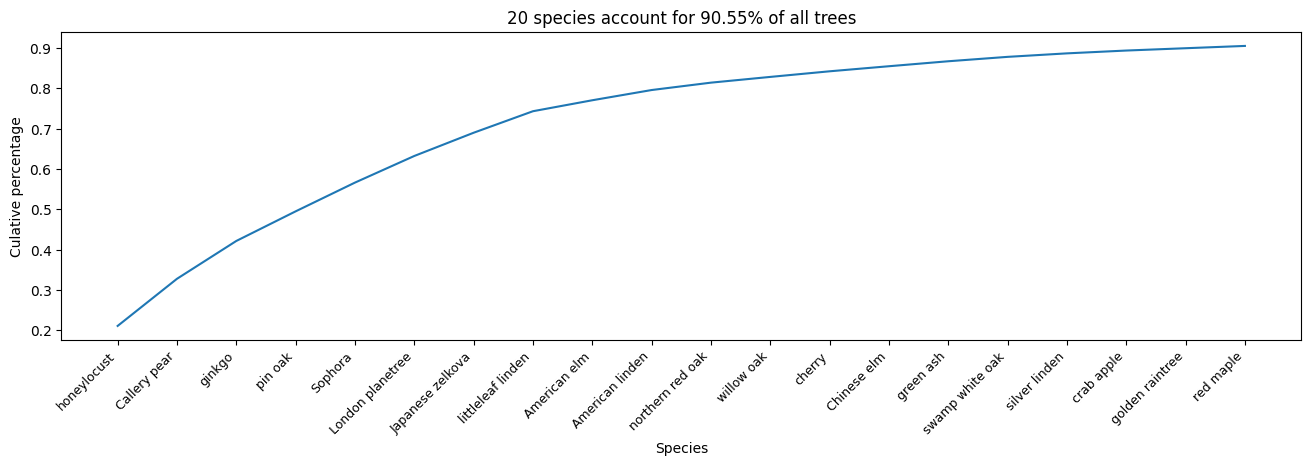

In [33]:
N_first_species = 20
species_percentage_cum = trees.spc_common.value_counts()[:N_first_species]/trees.spc_common.value_counts().sum()
with mpl.rc_context({'xtick.labelsize': 9}) :
    _, ax = plt.subplots(1,1,figsize=(16, 4))
    plt.xticks(np.arange(0, N_first_species))
    ax.set_xticklabels(trees.spc_common.value_counts()[:N_first_species].index, ha='right')
    ax.set_title(f'{N_first_species} species account for {round(1e2*species_percentage_cum.sum(),2)}% of all trees')
    ax.set_xlabel('Species')
    ax.set_ylabel('Culative percentage')
    species_percentage_cum.cumsum().plot(rot=45)

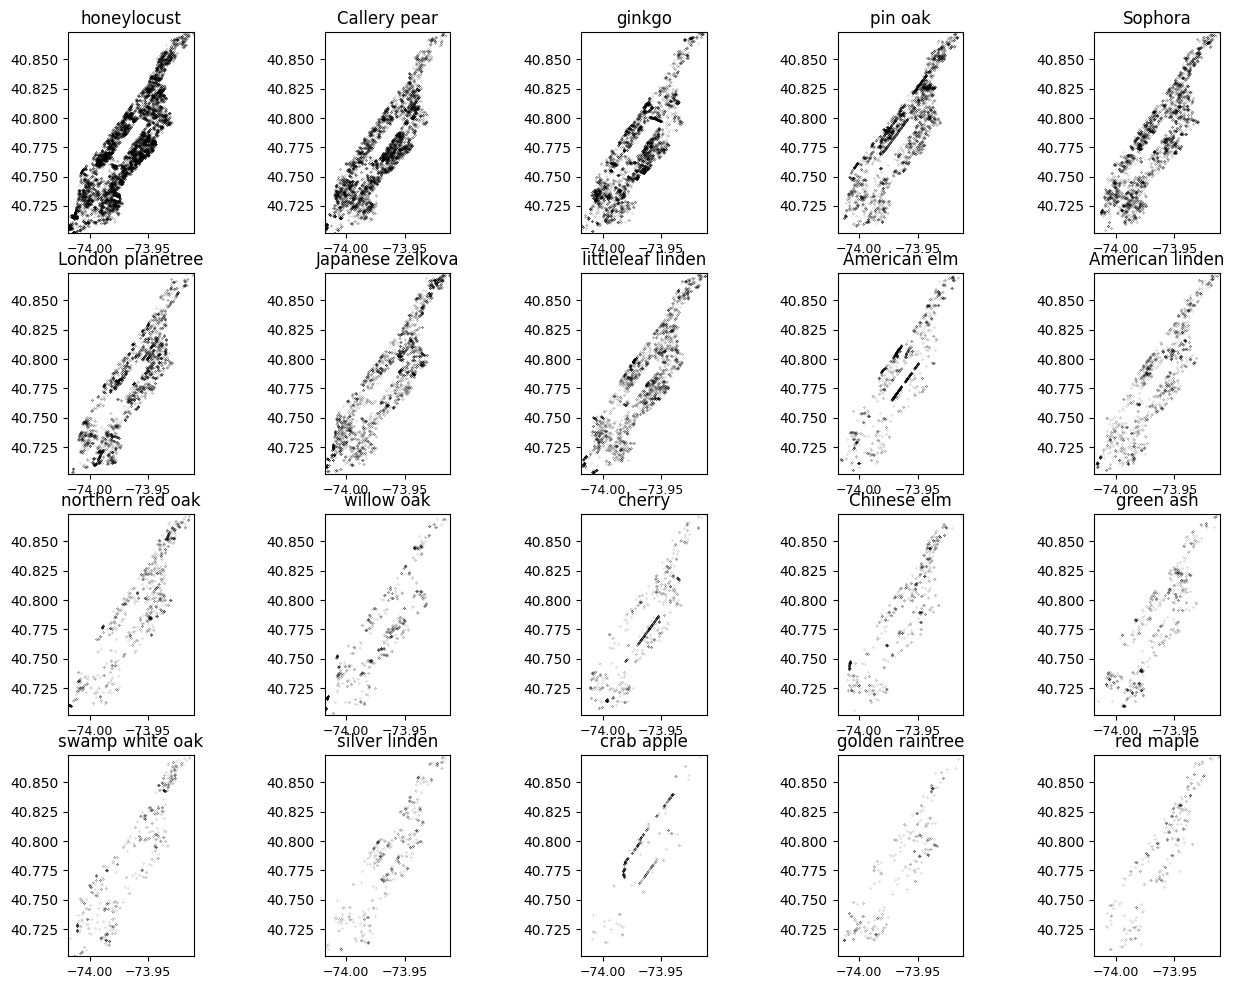

In [34]:
xmin1, ymin1, xmax1, ymax1  = trees.total_bounds
with mpl.rc_context({'axes.titlesize': 12, 'xtick.labelsize': 9}) :
    fig, axs = plt.subplots(4, 5, figsize=(16,12))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        ax.set_xlim(xmin1, xmax1)
        ax.set_ylim(ymin1, ymax1)
        ax.set_title(species_percentage_cum.keys()[i])
        trees[trees.spc_common == species_percentage_cum.keys()[i]].plot(ax=ax, markersize=0.01, color='black')

In [35]:
#fig.savefig('./images/scp_common_distribution.png')

### Look at tree health vs tree_dbh

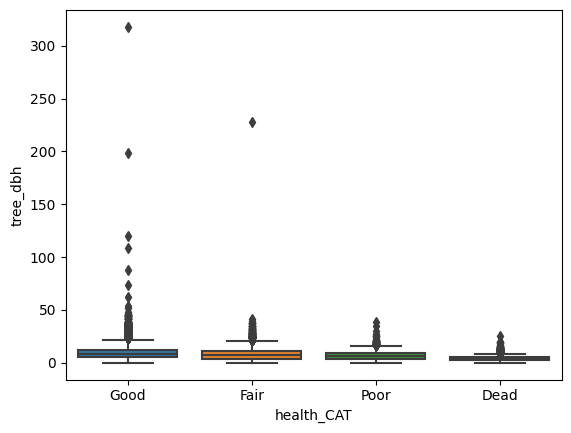

In [36]:
sns.boxplot(data=trees, x='health_CAT', y='tree_dbh');

### Plot concentration of trees on top of boroughs (Mannhattan only)

In [37]:
neighborhoods[neighborhoods['boroname']=='Manhattan'].head()

,borocode,boroname,countyfips,ntacode,ntaname,shape_area,shape_leng,geometry
23,1.0,Manhattan,061,MN22,East Village,1.089549e+07,13539.197632,"POLYGON ((-73.98256 40.73135, -73.98247 40.731..."
26,1.0,Manhattan,061,MN32,Yorkville,1.359478e+07,17409.210115,"MULTIPOLYGON (((-73.93805 40.78083, -73.93790 ..."
27,1.0,Manhattan,061,MN40,Upper East Side-Carnegie Hill,2.006533e+07,23778.406402,"POLYGON ((-73.94933 40.78519, -73.94982 40.784..."
38,1.0,Manhattan,061,MN09,Morningside Heights,2.015832e+07,20744.313555,"POLYGON ((-73.95210 40.81144, -73.95259 40.810..."
49,1.0,Manhattan,061,MN06,Manhattanville,1.064708e+07,17040.685731,"POLYGON ((-73.94608 40.82126, -73.94640 40.820..."


### SJOIN *trees* with *neighborhoods* (within)

In [62]:
!pip install fiona --upgrade

  Using cached Fiona-1.8.22-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
redshift-connector 2.0.908 requires pytz<2022.2,>=2020.1, but you have pytz 2022.7 which is incompatible.
pandas-profiling 3.4.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.1 which is incompatible.
mlflow 2.0.1 requires packaging<22, but you have packaging 22.0 which 

In [49]:
!pip install geopandas --upgrade

  Using cached geopandas-0.12.2-py3-none-any.whl (1.1 MB)
  Using cached pandas-1.5.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached pyproj-3.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached shapely-2.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Using cached Fiona-1.8.22-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached packaging-22.0-py3-none-any.whl (42 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached pytz-2022.7-py2.py3-none-any.whl (499 kB)

In [72]:
!pip install rtree --upgrade

  Using cached Rtree-1.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)


In [47]:
!pip install pygeos --upgrade

  Using cached pygeos-0.14-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
  Using cached numpy-1.24.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.4.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.1 which is incompatible.
mlflow 2.0.1 requires packaging<22, but you have packaging 22.0 which is incompatible.
cartopy 0.21.0 requires shapely<2,>=1.6.4, but you have shapely 2.0.0 which is incompatible.
pythonwhat 2.23.1 requires asttokens~=1.1.10, but you have asttokens 2.0.8 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.5.1 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.1.2 which is incompatible.


In [75]:
packagelist = !pip list
pd.Series(packagelist)[pd.Series(packagelist).str.contains('pandas|numpy|shapely|Fiona|pyproj|packaging|pygeos|Rtree')]

85     Fiona                             1.8.22
102    geopandas                         0.12.2
215    numpy                             1.24.1
230      packaging                         22.0
232     pandas                            1.5.2
233    pandas-datareader                 0.10.0
234     pandas-flavor                     0.3.0
235     pandas-ml                         0.6.1
236     pandas-profiling                  3.4.0
237     pandasql                          0.7.3
279      pygeos                            0.14
290     pyproj                            3.4.1
320     Rtree                             1.0.1
336     shapely                           2.0.0
dtype: object

In [76]:
pip install geopandas --upgrade

  Using cached geopandas-0.12.2-py3-none-any.whl (1.1 MB)
  Using cached packaging-22.0-py3-none-any.whl (42 kB)
  Using cached pandas-1.5.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached Fiona-1.8.22-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.6 MB)
  Using cached shapely-2.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.3 MB)
  Using cached pyproj-3.4.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.8 MB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached setuptools-65.6.3-py3-none-any.whl (1.2 MB)
  Using cached attrs-22.2.0-py3-none-any.whl (60 kB)
  Using cached python_dateutil-2.8.2-py2.py3-none-any.wh

In [79]:
!pip uninstall rtree --yes
!apt install libspatialindex-dev
!pip install rtree

Found existing installation: Rtree 1.0.1
Uninstalling Rtree-1.0.1:
  Successfully uninstalled Rtree-1.0.1
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
  Using cached Rtree-1.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)


In [81]:
!pip3 install rtree --upgrade

  Using cached Rtree-1.0.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)


In [87]:
!uname -v

#1 SMP Fri Feb 4 16:59:59 UTC 2022


### The actual sjoin command:

In [82]:
trees_w_boroughs = trees.sjoin(neighborhoods, how='left', predicate='within')

ImportError: Spatial indexes require either `rtree` or `pygeos`. See installation instructions at https://geopandas.org/install.html

In [45]:
# trees.geometry.apply(lambda tree: 
#                     neighborhoods[neighborhoods.contains(tree)].ntacode.tolist()
#                     )

0        [MN14]
1        [MN14]
2        [MN15]
3        [MN40]
4        [MN12]
          ...  
64224    [MN31]
64225    [MN25]
64226    [MN12]
64227    [MN21]
64228    [MN23]
Name: geometry, Length: 64229, dtype: object

In [84]:
ntacodesMhtn = [nbhd for nbhd in neighborhoods[neighborhoods.boroname=='Manhattan'].ntacode]

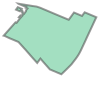

In [92]:
neighborhoods[neighborhoods.ntacode=='MN06'].geometry.iloc[0]

In [89]:
{(ntacode, neighborhoods[neighborhoods.ntacode==ntacode].geometry) for ntacode in ntacodesMhtn}

TypeError: unhashable type: 'GeoSeries'

In [99]:
neighborhoods.ntacode.apply(lambda itm: itm in ntacodesMhtn)

0      False
1      False
2      False
3      False
4      False
       ...  
190    False
191    False
192    False
193    False
194    False
Name: ntacode, Length: 195, dtype: bool

IndexError: index 1 is out of bounds for axis 0 with size 1

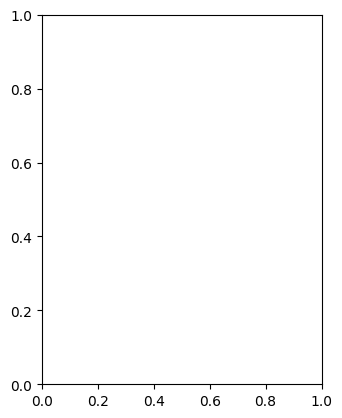

In [112]:
plot1 = neighborhoods[neighborhoods.ntacode.apply(lambda itm: itm in ntacodesMhtn)].plot(color=
                                                                                         cm.rainbow(
                                                                                             Normalize(vmin, vmax)
                                                                                             nta_tree_counts.values()))
#neighborhoods[neighborhoods.ntacode=='MN06'].plot(ax=plot1.axes, color='red')

In [108]:
nta_tree_counts = {ntacode: trees.geometry.within(neighborhoods[neighborhoods.ntacode==ntacode].geometry.iloc[0]).sum() for ntacode in ntacodesMhtn}

In [110]:
nta_tree_counts.values()

dict_values([1548, 2180, 4154, 2554, 899, 3761, 1451, 431, 1916, 1388, 2499, 3469, 2179, 1314, 1957, 1818, 2510, 2547, 1200, 1701, 2203, 2277, 2366, 5700, 2058, 1242, 2975, 1104, 2828])

In [66]:
neighborhoods[neighborhoods['boroname']=='Manhattan'].apply(lambda nbhd: trees.within(nbdh))

NameError: name 'nbdh' is not defined

In [57]:
neighborhoods.ntaname == None

0      False
1      False
2      False
3      False
4      False
       ...  
190    False
191    False
192    False
193    False
194    False
Name: ntaname, Length: 195, dtype: bool

In [55]:
def union_neighborhoods(exclude=None):
    type(neighborhoods[neighborhoods['boroname']=='Manhattan'].unary_union)

shapely.geometry.multipolygon.MultiPolygon

In [47]:
neighborhoods[neighborhoods['boroname']=='Manhattan'].unary_union.contains(geometry.Point(-74.05, 40.8))

False

<AxesSubplot:>

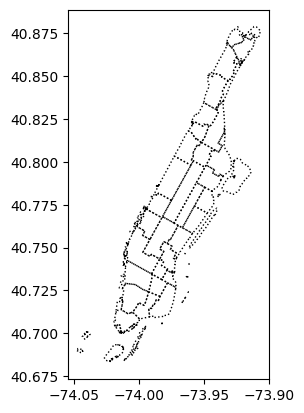

In [37]:
_, ax = plt.subplots(1,1)
ax.set_aspect(1)
neighborhoods[neighborhoods['boroname']=='Manhattan'].boundary.plot(ax = ax, edgecolor='black', linewidth=1, linestyle=':')

In [46]:
KDEDens = KDEMultivariate(data=np.vstack([trees.geometry.x, trees.geometry.y]).T, var_type='cc`')

def f_dens_vect(xv, yv):
  MN = xv.shape
  res = KDEDens.pdf(data_predict=
              np.hstack([xv.ravel().reshape(-1,1), yv.ravel().reshape(-1,1)])
              )
  return res.reshape(MN)

N_pixels = 12224/4
px_size = np.sqrt((xmax1 - xmin1) * (ymax1 - ymin1) / N_pixels)
print(px_size)

xx = np.linspace(xmin1, xmax1, round((xmax1-xmin1)/px_size))
yy = np.linspace(ymin1, ymax1, round((ymax1-ymin1)/px_size))
xv, yv = np.meshgrid(xx, yy, indexing='xy')

kde_plot2 = f_dens_vect(xv, yv)

ax.axes.imshow(
    np.ma.masked_where(kde_plot2 < kde_plot2.max()/10, kde_plot2),
    origin='lower', extent=(xmin1, xmax1, ymin1, ymax1), cmap='viridis')

0.0024505885583991347


NameError: name 'x_min' is not defined

### Plot trees locations with diameters color coded

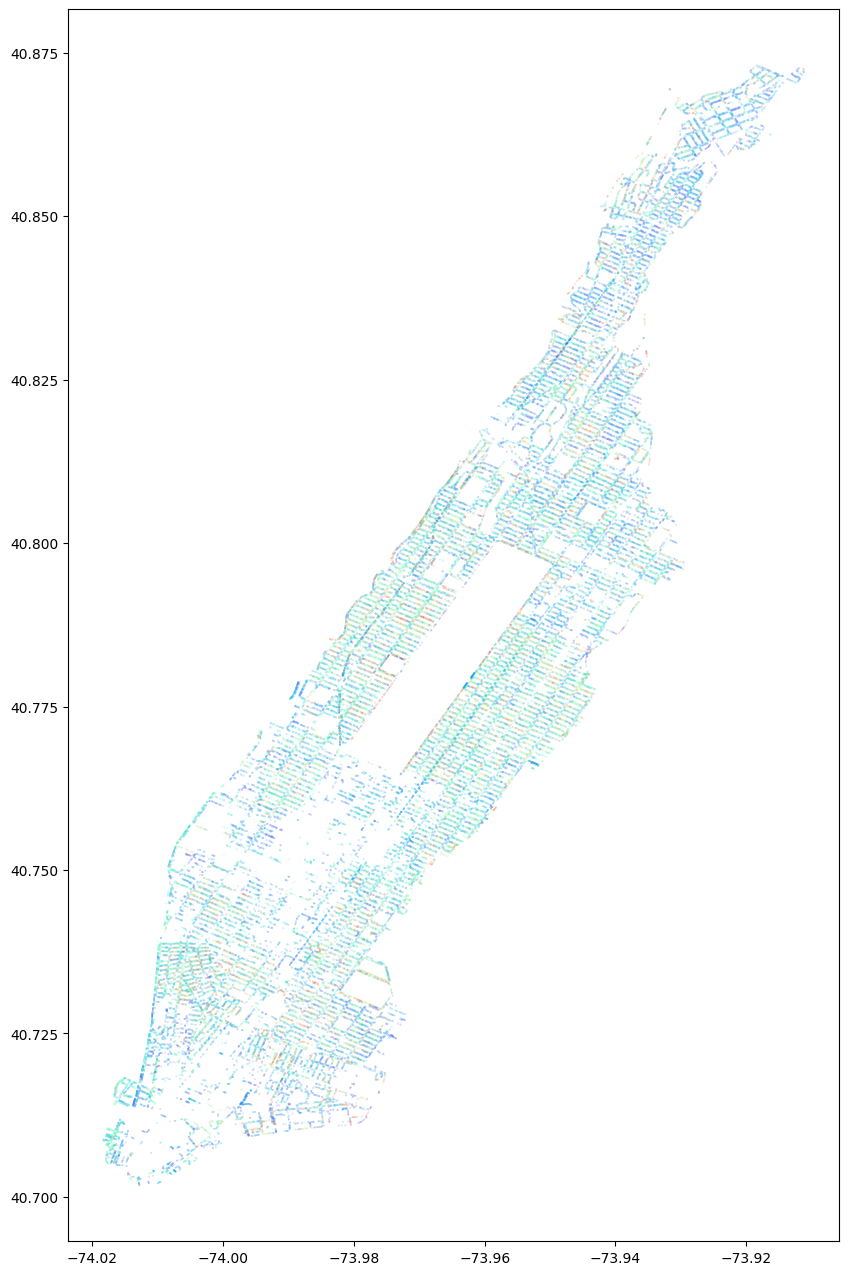

In [49]:
#Only plot diameters trees with diameters inside the "box", i.e. less than tree_dbh_bplot['fliers'][0].get_ydata().min()
_, ax = plt.subplots(1, 1, figsize=(16,16))
ax.set_aspect(1)
plot1 = trees[trees['tree_dbh']<tree_dbh_bplot['fliers'][0].get_ydata().min()].\
    plot(color=np.array(cm.rainbow(norm(trees[trees['tree_dbh']<tree_dbh_bplot['fliers'][0].get_ydata().min()]\
                                    ['tree_dbh'])))[:,:-1], markersize=0.01, ax=ax, alpha=1);

## Colors to code the tree health

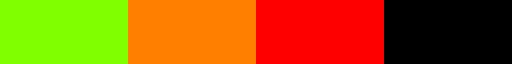

In [ ]:
ListedColormap([[0.5,1,0,1], [1,0.5,0,1], [1,0,0,1], [0,0,0,1]])

<AxesSubplot:>

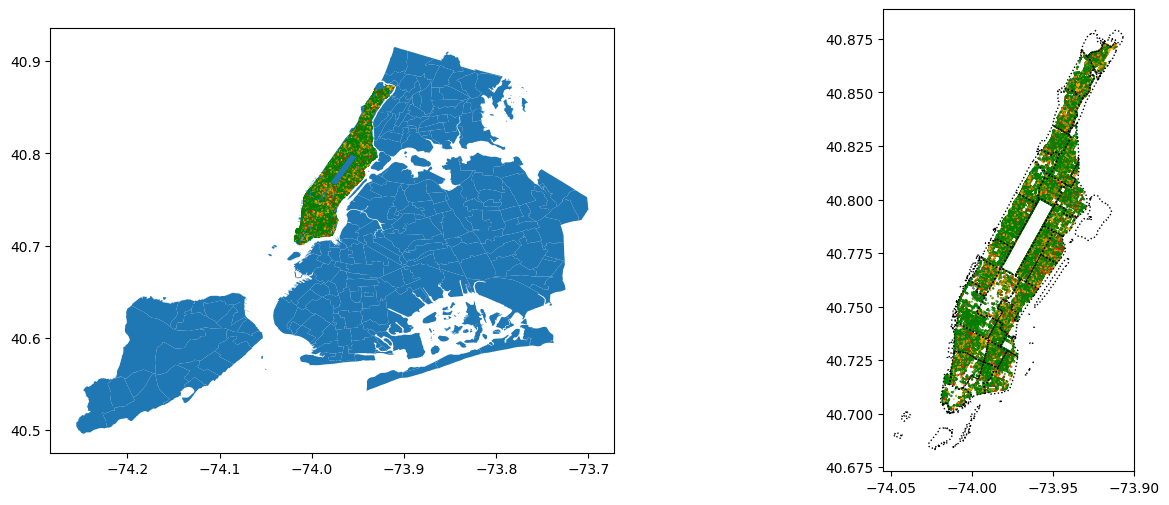

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,6))
neighborhoods.plot(ax = ax[0])
trees.plot(ax=ax[0], color=trees['health'].apply(lambda x: tree_health_cm[x]), markersize=0.1)
trees.plot(ax=ax[1], color=trees['health'].apply(lambda x: tree_health_cm[x]), markersize=0.1)
neighborhoods[neighborhoods['boroname']=='Manhattan'].boundary.plot(ax = ax[1], edgecolor='black', linewidth=1, linestyle=':')

## 💪 Challenge
Create a report that covers the following:
* What are the most common tree species in Manhattan?
* Which are the neighborhoods with the most trees?
* A visualization of Manhattan's neighborhoods and tree locations.
* What ten tree species would you recommend the city plant in the future?

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Response quality** | 85%       | <ul><li> Accuracy (30%) - The response must be representative of the original data and free from errors.</li><li> Clarity (25%) - The response must be easy to understand and clearly expressed.</li><li> Completeness (30%) - The response must be a full report that responds to the questions posed.</li></ul>       |
| **Presentation** | 15% | <ul><li>How legible/understandable the response is.</li><li>How well-formatted the response is.</li><li>Spelling and grammar.</li></ul> |

In the event of a tie, earlier submission time will be used as a tie-breaker. 

## 📘 Rules
To be eligible to win, you must:
* Submit your response before the deadline. 
All responses must be submitted in English.

Entrants must be:
* 18+ years old.
* Allowed to take part in a skill-based competition from their country.
Entrants can not:
* Be in a country currently sanctioned by the U.S. government.

## ✅ Checklist before publishing
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your work.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!